In [112]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer


In [118]:
class CFG:
    debug = False
    image_path = '/Users/jihyeonje/Downloads/PDBBind_processed/'
    captions_path ='/Users/jihyeonje/Downloads/PDBBind_processed/'
    batch_size = 32
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [119]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [120]:
import torch
from Bio.PDB import *
import numpy as np

def load_coords_from_pdb(
    pdb,
    atoms,
    method="raw",
    also_bfactors=False,
    normalize_bfactors=True,
):
    """
    Returns array of shape (1, n_res, len(atoms), 3)
    """

    coords = []
    bfactors = []
    if method == "raw":  # Raw numpy implementation, faster than biopdb
        # Indexing into PDB format, allowing XXXX.XXX
        coords_in_pdb = [slice(30, 38), slice(38, 46), slice(46, 54)]
        # Indexing into PDB format, allowing XXX.XX
        bfactor_in_pdb = slice(60, 66)

        with open(pdb, "r") as f:
            resi_prev = 1
            counter = 0
            for l in f:
                l_split = l.rstrip("\n").split()
                if len(l_split) > 0 and l_split[0] == "ATOM" and l_split[2] in atoms:
                    resi = l_split[5]
                    if resi == resi_prev:
                        counter += 1
                    else:
                        counter = 0
                    if counter < len(atoms):
                        xyz = [
                            np.array(l[s].strip()).astype(float) for s in coords_in_pdb
                        ]
                        coords.append(xyz)
                        if also_bfactors:
                            bfactor = np.array(l[bfactor_in_pdb].strip()).astype(float)
                            bfactors.append(bfactor)
                    resi_prev = resi
            coords = torch.Tensor(np.array(coords)).view(1, -1, len(atoms), 3)

    return coords


def get_dmap(pdb, atoms, batched=True, out="torch", device=None):
    """
        Returns a n-dim array of shape (bs, 1, n, n)

    """
    coords = load_coords_from_pdb(pdb, atoms=atoms).view(1, -1, 3)
    coords = coords.contiguous()
    dmaps = torch.cdist(coords, coords).unsqueeze(1)
    return dmaps.detach().cpu().numpy()[0][0]
    

In [123]:
# import required module
import os
# assign directory
directory = '/Users/jihyeonje/Downloads/PDBBind_processed/'

ligpaths = []
protpaths = []

# iterate over files in
# that directory
for dir in os.listdir(directory):
    if dir !='.DS_Store':
        foldr = os.path.join(directory, dir)
    for i in os.listdir(foldr):
        if i.endswith('.sdf'):
            ligpaths.append(os.path.join(foldr, i))
        elif i.endswith('.pdb'):
            protpaths.append(os.path.join(foldr, i))


In [124]:
import torchvision
import torchvision.transforms as T

In [125]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [126]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [127]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [128]:
# A simple Example

batch_size = 10
dim = 768
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [129]:
from rdkit import Chem


In [130]:
ligtxts = []
for p in ligpaths:
    suppl = Chem.SDMolSupplier(p, sanitize=False)
    smi = Chem.MolToSmiles(suppl[0])

    ligtxts.append(smi)

In [219]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        full_dist = []
        bkbone_atms = [['CA'], ['C'], ['N']]
        for a in bkbone_atms:
            full_dist.append(get_dmap(self.image_filenames[idx], a))
        
        img = np.moveaxis(np.array(full_dist),0,-1)
        img = self.transforms(image=img)['image']
        item['image'] = torch.tensor(img).permute(2,0,1).float()
        item['caption'] = self.captions[idx]

        return item

    def __len__(self):
        return len(self.captions)

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [220]:
protpaths_s = protpaths[:99]
ligtxts_s = ligtxts[:99]

In [221]:
def make_train_valid_dfs():
    max_id = len(protpaths_s)
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.arange(0, int(0.2*len(image_ids)),1)
    
    #valid_ids = np.random.choice(
    #    image_ids, size=int(0.2 * len(image_ids)), replace=False
    #)
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_prot = list(map(protpaths_s.__getitem__, train_ids))
    train_ligs = list(map(ligtxts_s.__getitem__, train_ids))
    valid_prot = list(map(protpaths_s.__getitem__, valid_ids))
    valid_ligs = list(map(ligtxts_s.__getitem__, valid_ids))
    return train_prot, train_ligs, valid_prot, valid_ligs


def build_loaders(prot, lig, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        prot,
        lig,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [222]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    
    train_prot, train_ligs, valid_prot, valid_ligs = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_prot, train_ligs, tokenizer, mode="train")
    valid_loader = build_loaders(valid_prot, valid_ligs, tokenizer, mode="valid")



    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [224]:
main()


Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

(3, 1818, 1818)
(1818, 1818, 3)
(3, 2082, 2082)
(2082, 2082, 3)
(3, 594, 594)
(594, 594, 3)
(3, 1056, 1056)
(1056, 1056, 3)
(3, 1065, 1065)
(1065, 1065, 3)
(3, 771, 771)
(771, 771, 3)
(3, 627, 627)
(627, 627, 3)
(3, 1143, 1143)
(1143, 1143, 3)
(3, 909, 909)
(909, 909, 3)
(3, 984, 984)
(984, 984, 3)
(3, 1596, 1596)
(1596, 1596, 3)
(3, 693, 693)
(693, 693, 3)
(3, 1185, 1185)
(1185, 1185, 3)
(3, 594, 594)
(594, 594, 3)
(3, 2310, 2310)
(2310, 2310, 3)
(3, 777, 777)
(777, 777, 3)
(3, 570, 570)
(570, 570, 3)
(3, 786, 786)
(786, 786, 3)
(3, 747, 747)
(747, 747, 3)
(3, 777, 777)
(777, 777, 3)
(3, 984, 984)
(984, 984, 3)
(3, 3318, 3318)
(3318, 3318, 3)
(3, 792, 792)
(792, 792, 3)
(3, 1119, 1119)
(1119, 1119, 3)
(3, 771, 771)
(771, 771, 3)
(3, 384, 384)
(384, 384, 3)
(3, 681, 681)
(681, 681, 3)
(3, 762, 762)
(762, 762, 3)
(3, 606, 606)
(606, 606, 3)
(3, 1632, 1632)
(1632, 1632, 3)
(3, 1581, 1581)
(1581, 1581, 3)
(3, 822, 822)
(822, 822, 3)


KeyboardInterrupt: 

In [82]:
def get_image_embeddings(val_img, val_txt, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(val_img, val_txt, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [83]:
_, _, val_prot, val_lig = make_train_valid_dfs()




model, image_embeddings = get_image_embeddings(val_prot, val_lig, "best.pt")

  0%|          | 0/1 [00:00<?, ?it/s]

In [111]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
encoded_query = tokenizer([query])
batch = {
    key: torch.tensor(values).to(CFG.device)
    for key, values in encoded_query.items()
}
text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
text_embeddings = model.text_projection(text_features)

NameError: name 'batch' is not defined

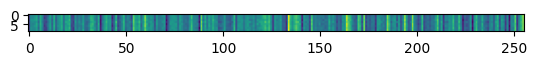

In [86]:
import matplotlib.pyplot as plt
plt.imshow(image_embeddings.detach().numpy())

In [109]:
def find_matches(model, image_embeddings, query, image_filenames, n=1):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    _, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    bkbone_atms = [['CA'], ['C'], ['N']]
    full_dist = []
    for a in bkbone_atms:
        full_dist.append(get_dmap(matches[0], a))
    plt.imshow(np.asarray(full_dist)[0,:,:])
    
    
    """
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        print(match)
        bkbone_atms = [['CA'], ['C'], ['N']]
        full_dist = []
        for a in bkbone_atms:
            full_dist.append(get_dmap(match, a))
        fin_img = np.moveaxis(np.array(full_dist),0,-1)

        ax.imshow(fin_img)
        ax.axis("off")
    """
    plt.show()

In [94]:
ligtxts[100]

'[H]C1=C([H])C1([H])N([H])C(=O)C1:C([H]):C([H]):C(C([H])([H])[H]):C(N([H])C(=O)C2:C([H]):C([H]):C3:C([H]):C([H]):N(C(=O)OC([H])([H])C([H])([H])[H]):C:3:C:2[H]):C:1[H]'

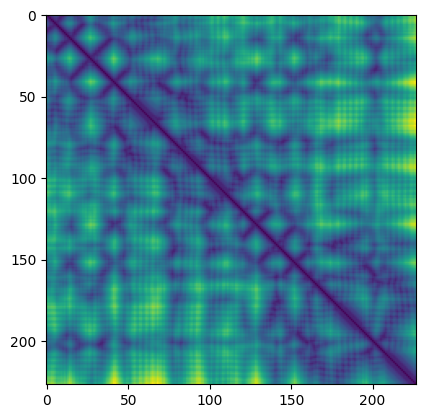

In [110]:
find_matches(model, 
             image_embeddings,
             query=ligtxts[100],
             image_filenames=val_prot,
             n=1)

In [ ]:
import torchvision
import torchvision.transforms as T
